In [1]:
# pip install --upgrade pystac-client

In [2]:
# pip show pystac_client

In [3]:
# imports
import pystac_client
import xarray as xr
import matplotlib.pyplot as plt
import pathlib
import os
import numpy as np
import geopandas as gpd
import matplotlib as mpl
from matplotlib import colors
import rasterio

import cartopy.crs as ccrs
import cartopy
import plotly.graph_objects as go
import plotly.express as px
from rasterio.plot import show

import matplotlib.colors as mcolors
from shapely.geometry import Point
import pandas as pd

from tqdm import tqdm


In [4]:
# opening STAC catalog, either a url, cloud storage link or a local (cloned) folder
cwd = pathlib.Path().resolve()

catalog = pystac_client.Client.open(
    "https://services.terrascope.be/stac/" # cloud API
    #os.path.join(os.path.dirname(cwd), "stac_folder", "current", "catalog.json") # local clone 
)
catalog

<Client id=terrascope>

In [5]:
list(catalog.get_children())

[<CollectionClient id=urn:eop:VITO:CGS_S1_GRD_L1>,
 <CollectionClient id=urn:eop:VITO:CGS_S1_GRD_SIGMA0_L1>,
 <CollectionClient id=urn:eop:VITO:CGS_S1_SLC_L1>,
 <CollectionClient id=urn:eop:VITO:CGS_S2_L1C>,
 <CollectionClient id=urn:eop:VITO:COP_DEM_EU_25M>,
 <CollectionClient id=urn:eop:VITO:COP_DEM_GLO_30M_COG>,
 <CollectionClient id=urn:eop:VITO:COP_DEM_GLO_90M_COG>,
 <CollectionClient id=urn:eop:VITO:ESA_WORLDCEREAL_ACTIVECROPLAND_V1>,
 <CollectionClient id=urn:eop:VITO:ESA_WORLDCEREAL_IRRIGATION_V1>,
 <CollectionClient id=urn:eop:VITO:ESA_WORLDCEREAL_MAIZE_V1>,
 <CollectionClient id=urn:eop:VITO:ESA_WORLDCEREAL_SPRINGCEREALS_V1>,
 <CollectionClient id=urn:eop:VITO:ESA_WORLDCEREAL_TEMPORARYCROPS_V1>,
 <CollectionClient id=urn:eop:VITO:ESA_WORLDCEREAL_WINTERCEREALS_V1>,
 <CollectionClient id=urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1>,
 <CollectionClient id=urn:eop:VITO:ESA_WorldCover_10m_2020_V1>,
 <CollectionClient id=urn:eop:VITO:ESA_WorldCover_10m_2021_AWS_V2>,
 <CollectionCli

In [6]:
collection= catalog.get_child("urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1")
collection

<CollectionClient id=urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1>

In [7]:
# b=list(catalog.get_collections())
# for collec in b:
#     print(f"{collec.id}")

In [8]:
items=list(collection.get_all_items())
print(f"Number of items: {len(items)}")
for item in items:
    print(f"- {item.id}")

Number of items: 100
- urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ESA_WorldCover_10m_2020_v100_N00E006
- urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ESA_WorldCover_10m_2020_v100_N00E009
- urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ESA_WorldCover_10m_2020_v100_N00E012
- urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ESA_WorldCover_10m_2020_v100_N00E015
- urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ESA_WorldCover_10m_2020_v100_N00E018
- urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ESA_WorldCover_10m_2020_v100_N00E021
- urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ESA_WorldCover_10m_2020_v100_N00E024
- urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ESA_WorldCover_10m_2020_v100_N00E027
- urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ESA_WorldCover_10m_2020_v100_N00E030
- urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ESA_WorldCover_10m_2020_v100_N00E033
- urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ESA_WorldCover_10m_2020_v100_N00E036
- urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ESA_WorldCover_10m_2

In [9]:
# World cover goes up in increments of 3 degrees

import math
tile_size=3
tile_prefix="urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ESA_WorldCover_10m_2020_v100_"

 


def find_tile_name(lat,lon,tile_size,tile_prefix):
    if lon>0:
        sign_lon="E"
    else:
        sign_lon="W"
    if lat>0:
        sign_lat="N"
    else:
        sign_lat="S"
    if abs(lat)<10:
        newlat="0"+str(abs(math.floor(lat/tile_size)*tile_size))
    else:
        newlat=str(abs(math.floor(lat/tile_size)*tile_size))

    if abs(lon)<10:
        newlon="00"+str(abs(math.floor(lon/tile_size)*tile_size))   
    elif abs(lon)<100:
        newlon="0"+str(abs(math.floor(lon/tile_size)*tile_size))
    else:
        newlon=str(abs(math.floor(lon/tile_size)*tile_size))
        
    tile_name=tile_prefix+ sign_lat+newlat+sign_lon+newlon
    return tile_name


#  eg item_id="ESA_WorldCover_10m_2020_v100_S57W072"


In [10]:
from rasterio.session import AWSSession

lon_x=-69.07256	
lat_y=12.18975	

# Define the AWS session
aws_session = rasterio.session.AWSSession(aws_unsigned=True, region_name='us-west-1')

# Assuming you have defined tile_name previously
tile_name = find_tile_name(lat_y, lon_x, tile_size, tile_prefix)
tile_name

# Assuming collection and href are defined previously
href = collection.get_item(tile_name).assets["ESA_WORLDCOVER_10M_MAP"].href

# Open the xarray dataset with AWS session
with rasterio.Env(aws_session):
    Land_use_xr = xr.open_dataset(href, engine="rasterio", mask_and_scale=False)
Land_use_xr

<xarray.Dataset>
Dimensions:      (band: 1, x: 36000, y: 36000)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -72.0 -72.0 -72.0 -72.0 ... -69.0 -69.0 -69.0 -69.0
  * y            (y) float64 15.0 15.0 15.0 15.0 15.0 ... 12.0 12.0 12.0 12.0
    spatial_ref  int32 ...
Data variables:
    band_data    (band, y, x) uint8 ...

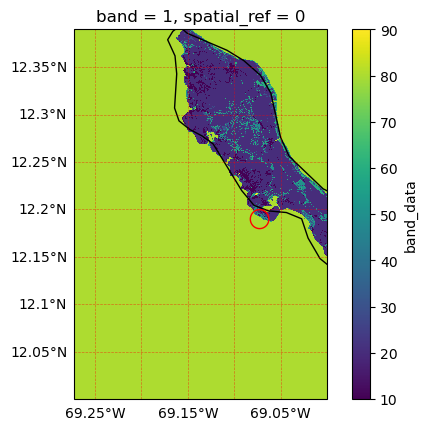

In [11]:
# Create a map projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the variable
Land_use_xr["band_data"].sel(x=slice(lon_x-.2,lon_x+.2),y=slice(lat_y+.2,lat_y-.2)).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')

# Add features like coastlines, borders, and ocean
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', edgecolor='black')
# ax.add_feature(cartopy.feature.OCEAN)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='red', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False


# Create a point geometry
point = Point(lon_x, lat_y)

# Create a GeoDataFrame from the point
gdf = gpd.GeoDataFrame(geometry=[point])

# Add a  1000m buffer around the point
gdf['geometry'] = gdf['geometry'].buffer(.01)

# Define the projection
crs = "EPSG:4326"  # WGS84
gdf.set_crs(crs, inplace=True)

# Plot the GeoDataFrame
# fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
gdf.plot(ax=ax, color='none', edgecolor='red')
# Plot the variable


# Show the plot
plt.show()

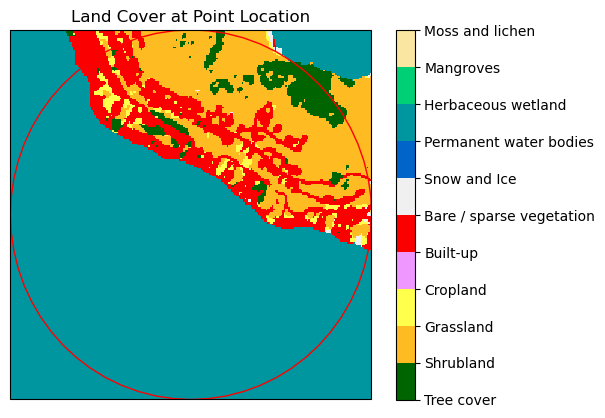

In [12]:

search_square=Land_use_xr["band_data"].sel(x=slice(lon_x-.01,lon_x+.01),y=slice(lat_y+.01,lat_y-.01))

# search_square.values = np.where(search_square.values != nodata_val, search_square.values, np.nan)


colors = ['#006400', '#FFBB22', '#FFFF4C', '#F096FF', '#FA0000', '#B4B4B4', '#F0F0F0', '#0064C8', '#0096A0', '#00CF75','#FAE6A0']
Land_cover_class = ['Tree cover', 'Shrubland', 'Grassland', 'Cropland', 'Built-up', 'Bare / sparse vegetation', 'Snow and Ice', 'Permanent water bodies', 'Herbaceous wetland', 'Mangroves','Moss and lichen']

cmap = mcolors.ListedColormap(colors)

# Create color bar
norm = mcolors.Normalize(vmin=10, vmax=100)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Create a new Axes for the Colorbar
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

cbar = fig.colorbar(sm, ax=ax, boundaries=np.linspace(10, 100, 11), ticks=np.linspace(10, 100, 11))
cbar.ax.set_yticklabels(Land_cover_class)

search_square.plot(ax=ax, cmap=cmap, vmin=10, vmax=100, add_colorbar=False)

point = Point(lon_x, lat_y)

# Create a GeoDataFrame from the point
gdf = gpd.GeoDataFrame(geometry=[point])

# Add a 1000m = 0.01degrees buffer around the point
gdf['geometry'] = gdf['geometry'].buffer(.01)

# Define the projection
crs = "EPSG:4326"  # WGS84
gdf.set_crs(crs, inplace=True)

gdf.plot(ax=ax, color='none', edgecolor='red')  # Create a point geometry
plt.title("Land Cover at Point Location")
plt.show()

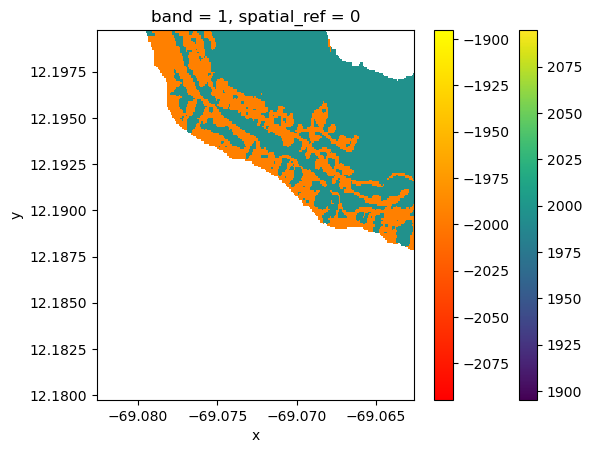

In [21]:
#Visualizing methodology
Permanent_water=80 
Built_up= 50
tile_size=3

search_radius=0.01 #Degress=1000m

tile_name = find_tile_name(lat_y, lon_x, tile_size, tile_prefix)


href = collection.get_item(tile_name).assets["ESA_WORLDCOVER_10M_MAP"].href
# Open the xarray dataset with AWS session
with rasterio.Env(aws_session):
    Land_use_xr = xr.open_dataset(href, engine="rasterio", mask_and_scale=False)
Land_use_xr

search_square=Land_use_xr["band_data"].sel(x=slice(lon_x-search_radius,lon_x+search_radius),y=slice(lat_y+search_radius,lat_y-search_radius))

non_permanent_water_values = np.where(~(search_square.values >= Permanent_water) & (search_square.values < Permanent_water + 10), 1995, np.nan)
non_permanent_water_values_da = xr.DataArray(non_permanent_water_values, coords=search_square.coords, dims=search_square.dims)

Built_up_values = np.where((search_square.values >= Built_up) & (search_square.values < Built_up + 10), -1995, np.nan)
Built_up_values_da = xr.DataArray(Built_up_values, coords=search_square.coords, dims=search_square.dims)

# Plot the modified data array
non_permanent_water_values_da.plot()
Built_up_values_da.plot(cmap='autumn')



In [24]:
#Calculations only for efficiency
Permanent_water=80 
Built_up= 50
tile_size=3

search_radius=0.01 #Degress=1000m

tile_name = find_tile_name(lat_y, lon_x, tile_size, tile_prefix)


href = collection.get_item(tile_name).assets["ESA_WORLDCOVER_10M_MAP"].href
# Open the xarray dataset with AWS session
with rasterio.Env(aws_session):
    Land_use_xr = xr.open_dataset(href, engine="rasterio", mask_and_scale=False)
Land_use_xr

search_square=Land_use_xr["band_data"].sel(x=slice(lon_x-search_radius,lon_x+search_radius),y=slice(lat_y+search_radius,lat_y-search_radius))

non_permanent_water_values = np.where(~(search_square.values >= Permanent_water) & (search_square.values < Permanent_water + 10), 2024, np.nan)

Built_up_values = np.where((search_square.values >= Built_up) & (search_square.values < Built_up + 10), -1995, np.nan)

#count (tiles == -1995)/ (tiles== 1995)

non_permanent_water_pixel_count=np.count_nonzero(non_permanent_water_values==2024)
Built_up_pixel_count=np.count_nonzero(Built_up_values==-1995)

built_up_perc=100*Built_up_pixel_count/non_permanent_water_pixel_count
print(f"{built_up_perc} %")



32.950593430858405 %


In [25]:
template_df=pd.read_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\All_Datasets\Orig_Datasets\04_Auxillary_files\Arjen_Vector_Template_Netherland_Antilles.csv")
template_df.head()

,transect_id,country_id,continent,country_name,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat
0,BOX_117_121_0,NLD,Europe,Netherlands,-68.395427,12.295109,-68.401033,12.301967,-68.406639,12.308825
1,BOX_117_121_1,NLD,Europe,Netherlands,-68.398505,12.292725,-68.404540,12.299226,-68.410576,12.305726
2,BOX_117_121_2,NLD,Europe,Netherlands,-68.401179,12.289979,-68.407654,12.296063,-68.414129,12.302147
3,BOX_117_121_3,NLD,Europe,Netherlands,-68.402839,12.287514,-68.410244,12.292483,-68.417649,12.297452
4,BOX_117_121_4,NLD,Europe,Netherlands,-68.403989,12.284926,-68.412179,12.288531,-68.420369,12.292136


In [26]:
template_df["built_up_perc"]=np.nan
template_df.head()

,transect_id,country_id,continent,country_name,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,built_up_perc
0,BOX_117_121_0,NLD,Europe,Netherlands,-68.395427,12.295109,-68.401033,12.301967,-68.406639,12.308825,NaN
1,BOX_117_121_1,NLD,Europe,Netherlands,-68.398505,12.292725,-68.404540,12.299226,-68.410576,12.305726,NaN
2,BOX_117_121_2,NLD,Europe,Netherlands,-68.401179,12.289979,-68.407654,12.296063,-68.414129,12.302147,NaN
3,BOX_117_121_3,NLD,Europe,Netherlands,-68.402839,12.287514,-68.410244,12.292483,-68.417649,12.297452,NaN
4,BOX_117_121_4,NLD,Europe,Netherlands,-68.403989,12.284926,-68.412179,12.288531,-68.420369,12.292136,NaN


In [27]:


#Calculations only for efficiency
Permanent_water=80 
Built_up= 50
tile_size=3

search_radius=0.01 #Degress=1000m


# for i in tqdm(range(len(template_df["Land_sub"]))[0:3],desc="row number"):
for i in tqdm(range(len(template_df["built_up_perc"])),desc="row number"):
    lon_x=template_df.iloc[i,6]
    lat_y=template_df.iloc[i,7]
    # lon_x=-77.4253
    # lat_y= 17.8684





    tile_name = find_tile_name(lat_y, lon_x, tile_size, tile_prefix)


    href = collection.get_item(tile_name).assets["ESA_WORLDCOVER_10M_MAP"].href
    # Open the xarray dataset with AWS session
    with rasterio.Env(aws_session):
        Land_use_xr = xr.open_dataset(href, engine="rasterio", mask_and_scale=False)
    Land_use_xr

    search_square=Land_use_xr["band_data"].sel(x=slice(lon_x-search_radius,lon_x+search_radius),y=slice(lat_y+search_radius,lat_y-search_radius))

    non_permanent_water_values = np.where(~(search_square.values >= Permanent_water) & (search_square.values < Permanent_water + 10), 2024, np.nan)

    Built_up_values = np.where((search_square.values >= Built_up) & (search_square.values < Built_up + 10), -1995, np.nan)

    #count (tiles == -1995)/ (tiles== 1995)

    non_permanent_water_pixel_count=np.count_nonzero(non_permanent_water_values==2024)
    Built_up_pixel_count=np.count_nonzero(Built_up_values==-1995)

    built_up_perc=100*Built_up_pixel_count/non_permanent_water_pixel_count
    
    template_df.iloc[i,10]=built_up_perc
template_df



row number: 100%|██████████| 623/623 [06:27<00:00,  1.61it/s]


,transect_id,country_id,continent,country_name,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,built_up_perc
0,BOX_117_121_0,NLD,Europe,Netherlands,-68.395427,12.295109,-68.401033,12.301967,-68.406639,12.308825,0.876549
1,BOX_117_121_1,NLD,Europe,Netherlands,-68.398505,12.292725,-68.404540,12.299226,-68.410576,12.305726,0.954057
2,BOX_117_121_2,NLD,Europe,Netherlands,-68.401179,12.289979,-68.407654,12.296063,-68.414129,12.302147,0.712364
3,BOX_117_121_3,NLD,Europe,Netherlands,-68.402839,12.287514,-68.410244,12.292483,-68.417649,12.297452,0.802819
4,BOX_117_121_4,NLD,Europe,Netherlands,-68.403989,12.284926,-68.412179,12.288531,-68.420369,12.292136,0.724815
...,...,...,...,...,...,...,...,...,...,...,...
618,BOX_117_117_139,NLD,Europe,Netherlands,-68.301764,12.158128,-68.300464,12.166817,-68.299164,12.175506,1.034188
619,BOX_117_117_140,NLD,Europe,Netherlands,-68.306208,12.158764,-68.304908,12.167453,-68.303608,12.176142,0.000000
620,BOX_117_117_141,NLD,Europe,Netherlands,-68.309252,12.158884,-68.309381,12.167664,-68.309510,12.176445,0.000000
621,BOX_117_117_142,NLD,Europe,Netherlands,-68.313743,12.158821,-68.313872,12.167601,-68.314001,12.176382,0.000000


In [28]:
template_df.to_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\02_Exposure\Built_up_perc-LandUse\Netherland_Antilles_built_up.csv",index=False)

In [29]:
template_df.iloc[:,10].describe()

count    623.000000
mean      17.033885
std       26.079201
min        0.000000
25%        0.721043
50%        3.225445
75%       20.874943
max       94.004372
Name: built_up_perc, dtype: float64

In [30]:
df=pd.read_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\02_Exposure\Built_up_perc-LandUse\Netherland_Antilles_built_up.csv")
df

,transect_id,country_id,continent,country_name,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,built_up_perc
0,BOX_117_121_0,NLD,Europe,Netherlands,-68.395427,12.295109,-68.401033,12.301967,-68.406639,12.308825,0.876549
1,BOX_117_121_1,NLD,Europe,Netherlands,-68.398505,12.292725,-68.404540,12.299226,-68.410576,12.305726,0.954057
2,BOX_117_121_2,NLD,Europe,Netherlands,-68.401179,12.289979,-68.407654,12.296063,-68.414129,12.302147,0.712364
3,BOX_117_121_3,NLD,Europe,Netherlands,-68.402839,12.287514,-68.410244,12.292483,-68.417649,12.297452,0.802819
4,BOX_117_121_4,NLD,Europe,Netherlands,-68.403989,12.284926,-68.412179,12.288531,-68.420369,12.292136,0.724815
...,...,...,...,...,...,...,...,...,...,...,...
618,BOX_117_117_139,NLD,Europe,Netherlands,-68.301764,12.158128,-68.300464,12.166817,-68.299164,12.175506,1.034188
619,BOX_117_117_140,NLD,Europe,Netherlands,-68.306208,12.158764,-68.304908,12.167453,-68.303608,12.176142,0.000000
620,BOX_117_117_141,NLD,Europe,Netherlands,-68.309252,12.158884,-68.309381,12.167664,-68.309510,12.176445,0.000000
621,BOX_117_117_142,NLD,Europe,Netherlands,-68.313743,12.158821,-68.313872,12.167601,-68.314001,12.176382,0.000000


In [32]:
import plotly.graph_objects as go

# Define your discrete color scale
color_scale = ['#D9EAD3', '#A9D08E', '#F9D670', '#FFA94D', '#FF704D', '#FF4D4D']

# Create the scatter mapbox plot using Plotly Graph Objects
fig2 = go.Figure(go.Scattermapbox(
    lat=df['Intersect_lat'],
    lon=df['Intersect_lon'],
    mode='markers',
    marker=dict(
        size=10,
        color=df['built_up_perc'],  # Use the 'Land_sub' column for color
        # colorscale=color_scale,  # Specify the discrete color scale
        # cmin=1,  # Set the minimum value for the color scale
        # cmax=6,  # Set the maximum value for the color scale
        colorbar=dict(
            title='Built up Percentage'  # Set color bar title
        )
    ),
    hoverinfo='text',
    hovertext=df['built_up_perc']
))

# Update layout properties
fig2.update_layout(
    title="Built up Percentage-Dutch Antilles",
    mapbox_style="carto-positron",
    mapbox=dict(
        zoom=8,
        center=dict(lat=12.18625, lon=-69.00168)
    ),		

    margin=dict(l=0, r=0, b=0, t=50),
)

# Show the plot
fig2.show()
